# Neural networks - Project 1
## Luis Filipe Menezes - RA: 164924

Este notebook foi feito como entrega para o 1º projeto da disciplina de Redes Neurais do Programa de Pós Gradução em Ciência da Computação (PPG-CC) da Univesidade Federal de São Paulo (UNIFESP).

Este projeto consiste em:

- Selecionar dois datasets (não triviais)

    - Um dataset para **classificação**

    - Um dataset para **regressão**

- Separar em treino/validação/teste

- Treinar modelos MLP para os dois problemas

- Considerar:

    - Diferentes topologias (>=5 topologias, variar número de camadas)
    - Usar o algoritmo original SGD (não usar algoritmos otimizados, e.g.ADAM)
    - Avaliar o impacto do uso do Momentum
    - Avaliar o impacto do uso da regularização (i.e. L2)

- Ilustrar graficamente a evolução do treinamento (treino/validação).

- Confeccionar um relatório (reprodutível) contendo os experimentos e resultados


# Predicting Crocodiles' conservation status

O primeiro problema a ser resolvido consiste em um problema de classificação utilizando um *dataset* sobre conservação de espécies de crocodilos.

O conjunto de dados possui 1000 amostras e 5 classes de status de conservação.

## Upload do dataset

Faremos o upload do *dataset* pela biblioteca **KaggleHub**.


In [ ]:
import sys
import subprocess
import pkg_resources

try:
    pkg_resources.get_distribution('kagglehub')
    print("A biblioteca kagglehub já está instalada.")
except pkg_resources.DistributionNotFound:
    print("A biblioteca kagglehub não foi encontrada. Instalando...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "kagglehub"])
    print("kagglehub instalado com sucesso.")

/tmp/ipython-input-478603028.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


A biblioteca kagglehub já está instalada.


In [ ]:
import kagglehub
import pandas as pd

# Download latest version
def download_and_load_dataset():
    path = kagglehub.dataset_download("zadafiyabhrami/global-crocodile-species-dataset") + "/crocodile_dataset.csv"
    df = pd.read_csv(path)
    return df, path

if __name__ == "__main__":
    df, path = download_and_load_dataset()
    print("Dataset preview: \n", df.info())

100%|██████████| 56.1k/56.1k [00:00<00:00, 1.19MB/s]

Extracting files...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Observation ID        1000 non-null   int64  
 1   Common Name           1000 non-null   object 
 2   Scientific Name       1000 non-null   object 
 3   Family                1000 non-null   object 
 4   Genus                 1000 non-null   object 
 5   Observed Length (m)   1000 non-null   float64
 6   Observed Weight (kg)  1000 non-null   float64
 7   Age Class             1000 non-null   object 
 8   Sex                   1000 non-null   object 
 9   Date of Observation   1000 non-null   object 
 10  Country/Region        1000 non-null   object 
 11  Habitat Type          1000 non-null   object 
 12  Conservation Status   1000 non-null   object 
 13  Observer Name         1000 non-null   object 
 14  Notes                 1000 non-null   object 
dtypes:

## Preparação de dados

Existem 15 atributos no total, no entanto, nem todos podem ser utilizados para classificação, e.g. *Common Name*, *Notes* ou *Family*.

Alguns atributos não faz sentido entregar para o modelo, visto que a correlação teórica é alta (e.g. *Scientific Name*, *Gênero*, se temos o nome científico da espécie, por equivalência também temos seu status de conservação).

In [ ]:

cleaned_df = df.drop(columns=['Common Name', 'Notes', 'Family',
                              'Observer Name', 'Scientific Name',
                              'Date of Observation', 'Observation ID', 'Genus', 'Country/Region'])

# Célula para inspecionar as colunas categóricas
categorical_cols = cleaned_df.select_dtypes(include=['object']).columns
print("Colunas categóricas restantes:\n", categorical_cols)
print("\nNúmero de valores únicos por coluna:")
print(cleaned_df[categorical_cols].nunique())

Colunas categóricas restantes:
 Index(['Age Class', 'Sex', 'Habitat Type', 'Conservation Status'], dtype='object')

Número de valores únicos por coluna:
Age Class               4
Sex                     3
Habitat Type           29
Conservation Status     5
dtype: int64


### Codificação e normalização de atributos
Das colunas categóricas restantes, vale a pena observar quais são apropriadas fazer **One-Hot Encoding** (1 de c), isto é, quais são **nominais** e quais são **ordinais**.

In [ ]:

cols_nominal = [ 'Conservation Status', 'Habitat Type', 'Sex'] # Categorias nominais

# Aplica o One-Hot Encoding
encoded_df = pd.get_dummies(cleaned_df, columns=cols_nominal)

print("Dimensões do DataFrame após One-Hot Encoding:", encoded_df.shape)
display(encoded_df.head())

Dimensões do DataFrame após One-Hot Encoding: (1000, 40)


,Observed Length (m),Observed Weight (kg),Age Class,Conservation Status_Critically Endangered,Conservation Status_Data Deficient,Conservation Status_Endangered,Conservation Status_Least Concern,Conservation Status_Vulnerable,Habitat Type_Billabongs,Habitat Type_Brackish Rivers,...,Habitat Type_Rivers,Habitat Type_Shaded Forest Rivers,Habitat Type_Slow Rivers,Habitat Type_Slow Streams,Habitat Type_Small Streams,Habitat Type_Swamps,Habitat Type_Tidal Rivers,Sex_Female,Sex_Male,Sex_Unknown
0,1.90,62.0,Adult,False,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,True,False
1,4.09,334.5,Adult,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2,1.08,118.2,Juvenile,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,2.42,90.4,Adult,False,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,True,False
4,3.75,269.4,Adult,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True


In [ ]:
cols_ordinal = ['Age Class', 'Conservation Status'] # Categorias ordinais

for col in cols_ordinal:
    print(df[col].value_counts())
    print("\n")

Age Class
Adult        510
Subadult     247
Juvenile     194
Hatchling     49
Name: count, dtype: int64


Conservation Status
Least Concern            384
Critically Endangered    275
Vulnerable               170
Data Deficient           115
Endangered                56
Name: count, dtype: int64




Note que o status de conservação, nossa classe a ser predita, possui uma categoria como *data deficient*, o que é cerca de $11,5$% do nosso conjunto de dados... Isso corresponde à duas especies que não temos dados sobre conservação.

Aqui nos encontramos com duas alternativas:
 - Retirar os dados faltantes.
 - Utilizar este como uma classe independente.

 Como o nosso conjunto de dados é pequeno e o modelo não será aplicado na industria, podemos utilizar estes como uma classe independente por si só.

In [ ]:
df['Scientific Name'][cleaned_df['Conservation Status'] == 'Data Deficient'].unique()

array(['Osteolaemus osborni', 'Crocodylus raninus'], dtype=object)

In [ ]:
age_class_mapper = {
    "Hatchling": 0,
    "Juvenile": 1,
    "Subadult": 2,
    "Adult": 3
}

encoded_df['Age Class'] = encoded_df['Age Class'].map(age_class_mapper)
display(encoded_df.head())

,Observed Length (m),Observed Weight (kg),Age Class,Conservation Status_Critically Endangered,Conservation Status_Data Deficient,Conservation Status_Endangered,Conservation Status_Least Concern,Conservation Status_Vulnerable,Habitat Type_Billabongs,Habitat Type_Brackish Rivers,...,Habitat Type_Rivers,Habitat Type_Shaded Forest Rivers,Habitat Type_Slow Rivers,Habitat Type_Slow Streams,Habitat Type_Small Streams,Habitat Type_Swamps,Habitat Type_Tidal Rivers,Sex_Female,Sex_Male,Sex_Unknown
0,1.90,62.0,3,False,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,True,False
1,4.09,334.5,3,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2,1.08,118.2,1,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,2.42,90.4,3,False,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,True,False
4,3.75,269.4,3,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True


Para **normalização**, vamos observar as classes numéricas.
Para decidir qual método de normalização será utilizado, por distribuição ou utilizando minMaxScaler, precisamos analisar a presença de outliers nos dados numéricos, visto que utilizando o minMaxScaler podemos acabar

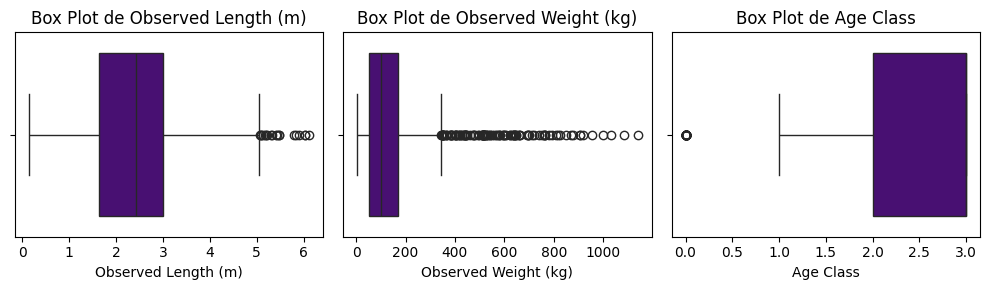

       Observed Length (m)  Observed Weight (kg)    Age Class
count          1000.000000           1000.000000  1000.000000
mean              2.415110            155.771900     2.218000
std               1.097542            175.186788     0.923758
min               0.140000              4.400000     0.000000
25%               1.637500             53.225000     2.000000
50%               2.430000            100.600000     3.000000
75%               3.010000            168.875000     3.000000
max               6.120000           1139.700000     3.000000


In [ ]:
numeric_cols = encoded_df.select_dtypes(include=['int', 'float64']).columns

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(10, 3))

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=encoded_df[col], ax=axes[i], color='indigo')
    axes[i].set_title(f'Box Plot de {col}')

plt.tight_layout()
plt.show()
print(encoded_df[numeric_cols].describe())

Como a classe *Observed Weight* possui muitos outliers, vamos utilizar normalização por distribuição, utilizando o módulo *StandartScaler* do *scikitlearn*

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(encoded_df[numeric_cols])
encoded_df[numeric_cols] = scaler.transform(encoded_df[numeric_cols])
display(encoded_df[numeric_cols].describe())

,Observed Length (m),Observed Weight (kg),Age Class
count,1.000000e+03,1.000000e+03,1.000000e+03
mean,1.136868e-16,7.283063e-17,2.309264e-17
std,1.000500e+00,1.000500e+00,1.000500e+00
min,-2.073951e+00,-8.644924e-01,-2.402262e+00
25%,-7.088557e-01,-5.856504e-01,-2.361106e-01
50%,1.357346e-02,-3.150894e-01,8.469654e-01
75%,5.422914e-01,7.483245e-02,8.469654e-01
max,3.377313e+00,5.619262e+00,8.469654e-01


## Desenvolvimento de modelos

### Divisão do conjunto de dados

Utilizaremos divisão estratificada para preservar a proporção entre as classes.

In [ ]:
cols_to_predict = ['Conservation Status_Least Concern', 'Conservation Status_Critically Endangered', 'Conservation Status_Endangered', 'Conservation Status_Data Deficient',  'Conservation Status_Vulnerable']

Y = encoded_df[cols_to_predict]
X = encoded_df.drop(columns=cols_to_predict)
X.head()

,Observed Length (m),Observed Weight (kg),Age Class,Habitat Type_Billabongs,Habitat Type_Brackish Rivers,Habitat Type_Coastal Lagoons,Habitat Type_Coastal Wetlands,Habitat Type_Estuaries,Habitat Type_Estuarine Systems,Habitat Type_Flooded Savannas,...,Habitat Type_Rivers,Habitat Type_Shaded Forest Rivers,Habitat Type_Slow Rivers,Habitat Type_Slow Streams,Habitat Type_Small Streams,Habitat Type_Swamps,Habitat Type_Tidal Rivers,Sex_Female,Sex_Male,Sex_Unknown
0,-0.469565,-0.535536,0.846965,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
1,1.526801,1.020725,0.846965,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,-1.217063,-0.214575,-1.319187,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
3,0.004458,-0.373342,0.846965,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
4,1.216862,0.648936,0.846965,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True


In [ ]:
from sklearn.model_selection import train_test_split

X_dev, X_test, Y_dev, Y_test = train_test_split(X, Y, test_size=0.1, random_state=24, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=0.2, random_state=24, stratify=Y_dev)

print("Tamanho do conjunto de treino:", X_train.shape)
print("Número de classes preditas:", Y_test.shape[1])

Tamanho do conjunto de treino: (720, 35)
Número de classes preditas: 5


### Modelo 0 - MLP sem *momentum*
Utilizando os seguintes hiperparâmetros:
- 5 neurônios na camada oculta.
- $lr= 0.1$
- Divisão estratificada do banco de dados.
- Treinamento em *batch* (tamanho = 100).

In [ ]:
import keras
from keras.layers import Dense, Input

model = keras.Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(5, activation='relu'))
model.add(Dense(Y_train.shape[1], activation='softmax'))


In [ ]:
from keras.optimizers import SGD

optimizer = SGD(learning_rate=0.1, momentum=0.0)

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 5)              │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 5)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210 (840.00 B)

 Trainable params: 210 (840.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, Y_train, epochs=800,
                     validation_data=(X_val, Y_val),
                     batch_size=100, verbose=0)

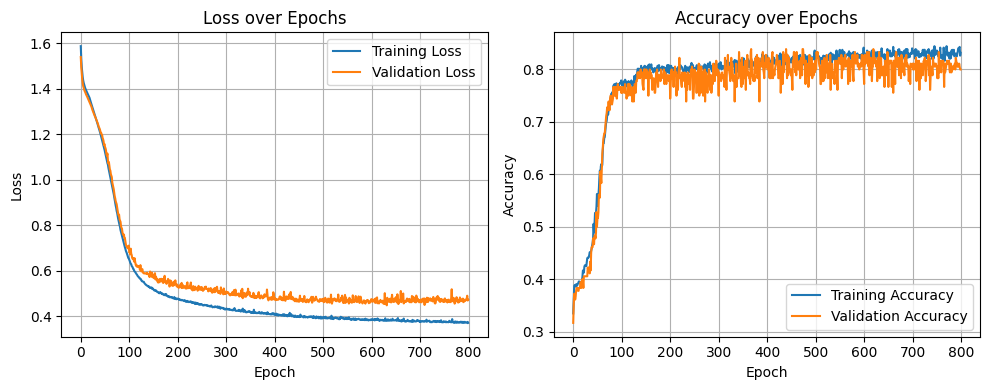

In [ ]:
#@title Gráfico de custo durante aprendizado
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.


    Args:
        history: A Keras History object.
    """
    plt.figure(figsize=(10, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

In [ ]:
val_loss, val_acc = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7911 - loss: 0.4761 
Validation Loss: 0.4726
Validation Accuracy: 0.8000


#### Comentários:

É possível perceber que o modelo se encontra em *underfitting*, ou seja, os 5 neurônios na camada oculta parecem não ser suficiente para convergir o modelo.

Além disso, visto que o treinamento está sendo em batch, a oscilação entre as épocas deve se dar pela alta taxa de aprendizado.

Vamos portanto aumentar o número de neurônios na camada oculta e avaliar se a camada oculta conseguirá reduzir a dimensionalidade para um $R^5$ linearmente separável.

### Modelo 1 - MLP sem *momentum*
Utilizando os seguintes hiperparâmetros:
- 20 neurônios na camada oculta.
- $lr= 0.1$
- Divisão estratificada do banco de dados.
- Treinamento em *batch* (tamanho = 100).

In [ ]:
import keras
from keras.layers import Dense, Input

model = keras.Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(20, activation='relu'))
model.add(Dense(Y_train.shape[1], activation='softmax'))


In [ ]:
from keras.optimizers import SGD

optimizer = SGD(learning_rate=0.1, momentum=0.0)

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 20)             │           720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 825 (3.22 KB)

 Trainable params: 825 (3.22 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, Y_train, epochs=800,
                     validation_data=(X_val, Y_val),
                     batch_size=100, verbose=0,)

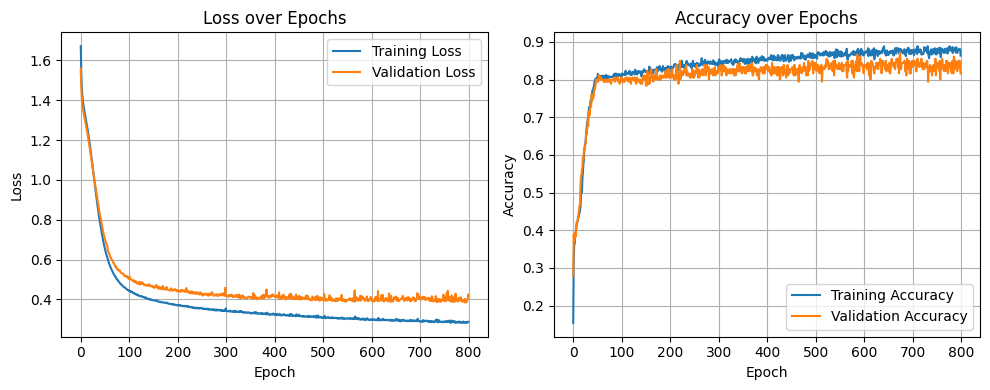

In [ ]:
#@title Gráfico de custo durante aprendizado
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.


    Args:
        history: A Keras History object.
    """
    plt.figure(figsize=(10, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

In [ ]:
val_loss, val_acc = model.evaluate(X_val, Y_val)
train_loss, train_acc = model.evaluate(X_train, Y_train)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7974 - loss: 0.4388 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8626 - loss: 0.3132 
Validation Loss: 0.4241
Validation Accuracy: 0.8167
Train Loss: 0.3129
Train Accuracy: 0.8583


#### Comentários:

Houve uma certa melhora na acurácia de validação. Talvez com uma nova camada oculta seja possível analisar representar melhor o problema.

### Modelo 2 - MLP sem *momentum*
Utilizando os seguintes hiperparâmetros:
- 20 neurônios na primeira camada oculta.
- 5 na segunda camada oculta.
- $lr= 0.1$
- Divisão estratificada do banco de dados.
- Treinamento em *batch* (tamanho = 100).

In [ ]:
import keras
from keras.layers import Dense, Input

model = keras.Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(Y_train.shape[1], activation='softmax'))


In [ ]:
from keras.optimizers import SGD

optimizer = SGD(learning_rate=0.1, momentum=0.0)

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 30)             │         1,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 5)              │            80 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625 (6.35 KB)

 Trainable params: 1,625 (6.35 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, Y_train, epochs=800,
                     validation_data=(X_val, Y_val),
                     batch_size=100, verbose=0,)

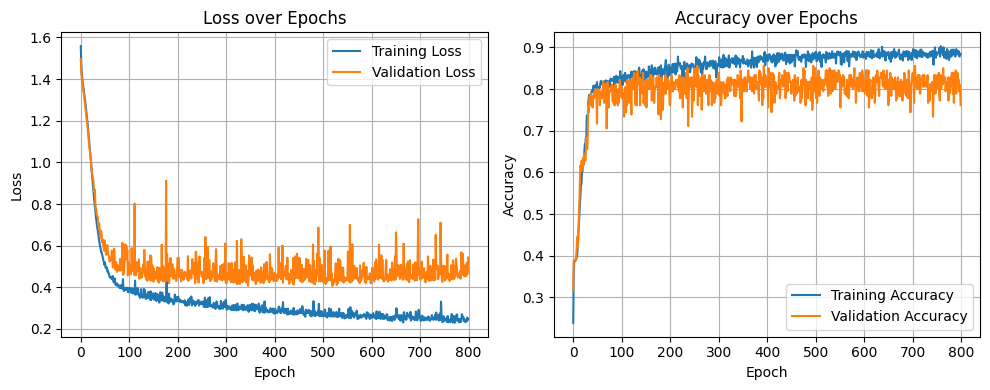

In [ ]:
#@title Gráfico de custo durante aprendizado
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.


    Args:
        history: A Keras History object.
    """
    plt.figure(figsize=(10, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

In [ ]:
val_loss, val_acc = model.evaluate(X_val, Y_val)
train_loss, train_acc = model.evaluate(X_train, Y_train)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.7420 - loss: 0.5288
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8312 - loss: 0.3491
Validation Loss: 0.5434
Validation Accuracy: 0.7611
Train Loss: 0.3226
Train Accuracy: 0.8486


#### Comentários:

A rede apresentou mais ruído com uma camada a mais, mostrando que adicionar outra camada pode explicitar a magnitude da taxa de aprendizado, evidenciando a alta taxa de aprendizado e longos passos para o mínimo global.

### Modelo 3 - MLP sem *momentum*
Utilizando os seguintes hiperparâmetros:
- 30 neurônios na primeira camada oculta.
- 15 na segunda camada oculta.
- $lr= 0.01$
- Divisão estratificada do banco de dados.
- Treinamento em *batch* (tamanho = 100).

In [ ]:
import keras
from keras.layers import Dense, Input

model = keras.Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(Y_train.shape[1], activation='softmax'))


In [ ]:
from keras.optimizers import SGD

optimizer = SGD(learning_rate=0.01, momentum=0.0)

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 30)             │         1,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 5)              │            80 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625 (6.35 KB)

 Trainable params: 1,625 (6.35 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, Y_train, epochs=800,
                     validation_data=(X_val, Y_val),
                     batch_size=100, verbose=0,)

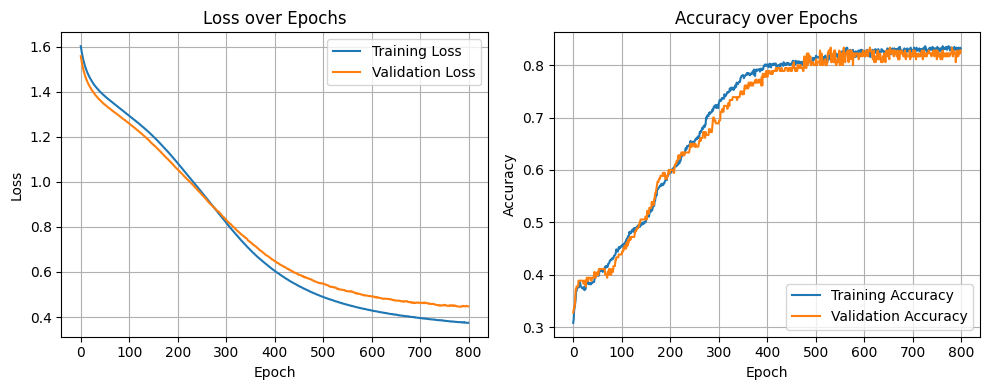

In [ ]:
#@title Gráfico de custo durante aprendizado
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.


    Args:
        history: A Keras History object.
    """
    plt.figure(figsize=(10, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

In [ ]:
val_loss, val_acc = model.evaluate(X_val, Y_val)
train_loss, train_acc = model.evaluate(X_train, Y_train)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8140 - loss: 0.4678
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8268 - loss: 0.3947
Validation Loss: 0.4474
Validation Accuracy: 0.8278
Train Loss: 0.3735
Train Accuracy: 0.8361


#### Comentários:

Diminuir a taxa de aprendizado faz com que o modelo tome passos menores, diminuindo significativamente o ruído na curva de treinamento.

No entanto, o modelo ainda demora quase $500$ épocas para convergir em uma acurácia de $0.8$. Vamos agora adicionar *momentum* e analisar de o modelo consegue convergir mais rápido também melhorar a acurácia de validação.

### Modelo 4 - MLP **com** *momentum*
Utilizando os seguintes hiperparâmetros:
- 30 neurônios na primeira camada oculta.
- 15 na segunda camada oculta.
- $lr= 0.01$
- *momentum* $=0.9$
- Divisão estratificada do banco de dados.
- Treinamento em *batch* (tamanho = 100).

In [ ]:
import keras
from keras.layers import Dense, Input

model = keras.Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(Y_train.shape[1], activation='softmax'))


In [ ]:
from keras.optimizers import SGD

optimizer = SGD(learning_rate=0.01, momentum=0.9)

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 30)             │         1,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 5)              │            80 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625 (6.35 KB)

 Trainable params: 1,625 (6.35 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, Y_train, epochs=800,
                     validation_data=(X_val, Y_val),
                     batch_size=100, verbose=0,)

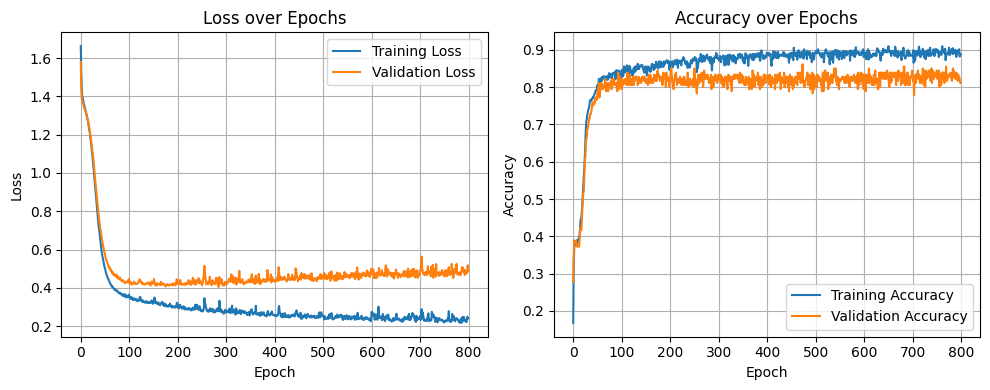

In [ ]:
#@title Gráfico de custo durante aprendizado
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.


    Args:
        history: A Keras History object.
    """
    plt.figure(figsize=(10, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

In [ ]:
val_loss, val_acc = model.evaluate(X_val, Y_val)
train_loss, train_acc = model.evaluate(X_train, Y_train)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8088 - loss: 0.4737
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8966 - loss: 0.2502
Validation Loss: 0.4887
Validation Accuracy: 0.8111
Train Loss: 0.2698
Train Accuracy: 0.8764


#### Comentários:

Ao adicionar *momentum*, há uma queda maior na curva de treinamento nas épocas iniciais, convergindo para um custo baixo e alta acurácia nas épocas iniciais. O que mostra a influência do *momentum* no ajuste dos pesos. No entanto, após algumas épocas(cerca de $200$), o *momentum* acumulado passa a tornar o passo de atualização dos pesos muito maior que o desejado, formando as oscilações mostradas no gráfico (*overshooting*).

Ainda assim, é possível notar o *overfitting* do modelo após $500$ épocas. Adicionar métodos de regularização pode apaziguar esse cenário.



### Modelo 5 - MLP **com** *momentum*
Utilizando os seguintes hiperparâmetros:
- 30 neurônios na primeira camada oculta.
- 15 na segunda camada oculta.
- $lr= 0.01$
- *momentum* $=0.7$
- Divisão estratificada do banco de dados.
- Treinamento em *batch* (tamanho = 100).

In [ ]:
import keras
from keras.layers import Dense, Input

model = keras.Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(Y_train.shape[1], activation='softmax'))


In [ ]:
from keras.optimizers import SGD

optimizer = SGD(learning_rate=0.01, momentum=0.7)

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 30)             │         1,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 5)              │            80 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625 (6.35 KB)

 Trainable params: 1,625 (6.35 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, Y_train, epochs=800,
                     validation_data=(X_val, Y_val),
                     batch_size=100, verbose=0,)

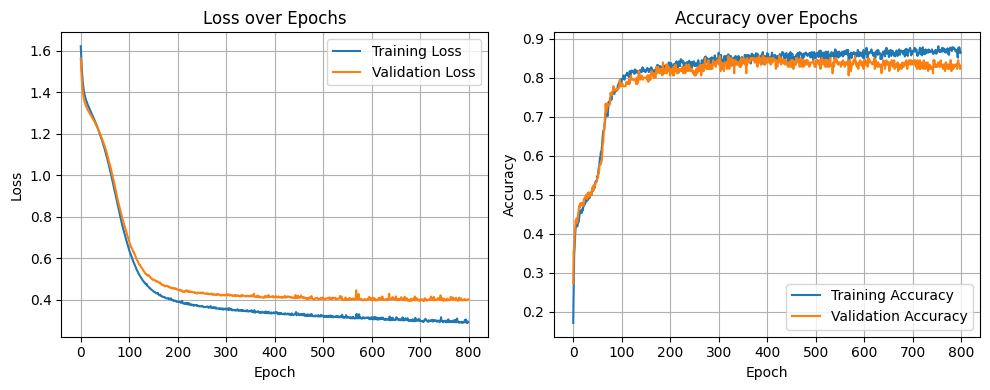

In [ ]:
#@title Gráfico de custo durante aprendizado
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.


    Args:
        history: A Keras History object.
    """
    plt.figure(figsize=(10, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

In [ ]:
val_loss, val_acc = model.evaluate(X_val, Y_val)
train_loss, train_acc = model.evaluate(X_train, Y_train)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8373 - loss: 0.4099
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8761 - loss: 0.3002
Validation Loss: 0.4009
Validation Accuracy: 0.8278
Train Loss: 0.2827
Train Accuracy: 0.8861


#### Comentários:

Ao diminuir um pouco o *momentum*, diminuímos também o *overshooting* do modelo, mantendo a rápida convergência mas diminuindo significativamente o ruído das curvas. Agora, resta adicionar métodos de regularização e analisar seus impactos para o modelo.



### Modelo 6 - MLP **com** *momentum*
Utilizando os seguintes hiperparâmetros:
- 30 neurônios na primeira camada oculta.
- 15 na segunda camada oculta.
- $lr= 0.01$.
- *momentum* $=0.7$.
- Regularização **L1**.
- Divisão estratificada do banco de dados.
- Treinamento em *batch* (tamanho = 100).

In [ ]:
import keras
from keras.layers import Dense, Input

model = keras.Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(30, activation='relu', kernel_regularizer='l1'))
model.add(Dense(15, activation='relu', kernel_regularizer='l1'))
model.add(Dense(Y_train.shape[1], activation='softmax'))


In [ ]:
from keras.optimizers import SGD

optimizer = SGD(learning_rate=0.01, momentum=0.7)

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_46 (Dense)                │ (None, 30)             │         1,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 5)              │            80 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625 (6.35 KB)

 Trainable params: 1,625 (6.35 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, Y_train, epochs=800,
                     validation_data=(X_val, Y_val),
                     batch_size=100, verbose=0,)

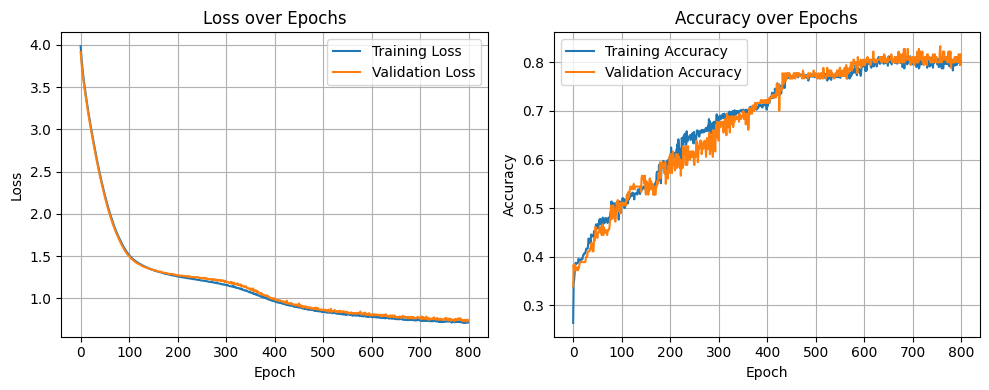

In [ ]:
#@title Gráfico de custo durante aprendizado
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.


    Args:
        history: A Keras History object.
    """
    plt.figure(figsize=(10, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

In [ ]:
val_loss, val_acc = model.evaluate(X_val, Y_val)
train_loss, train_acc = model.evaluate(X_train, Y_train)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.8173 - loss: 0.7552
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8019 - loss: 0.7266
Validation Loss: 0.7419
Validation Accuracy: 0.8167
Train Loss: 0.7153
Train Accuracy: 0.8083


#### Comentários:

Ao adicionar **L1** é possível observar um colamento da curva de validação com a curva de treino.



### Modelo 7 - MLP **com** *momentum* e regularização
Utilizando os seguintes hiperparâmetros:
- 30 neurônios na primeira camada oculta.
- 15 na segunda camada oculta.
- $lr= 0.01$.
- *momentum* $=0.7$.
- Regularização **L2**.
- Divisão estratificada do banco de dados.
- Treinamento em *batch* (tamanho = $100$).

In [ ]:
import keras
from keras.layers import Dense, Input

model = keras.Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(30, activation='relu', kernel_regularizer='l2'))
model.add(Dense(15, activation='relu', kernel_regularizer='l2'))
model.add(Dense(Y_train.shape[1], activation='softmax'))


In [ ]:
from keras.optimizers import SGD

optimizer = SGD(learning_rate=0.01, momentum=0.7)

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 30)             │         1,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 5)              │            80 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625 (6.35 KB)

 Trainable params: 1,625 (6.35 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, Y_train, epochs=1000,
                     validation_data=(X_val, Y_val),
                     batch_size=100, verbose=0)

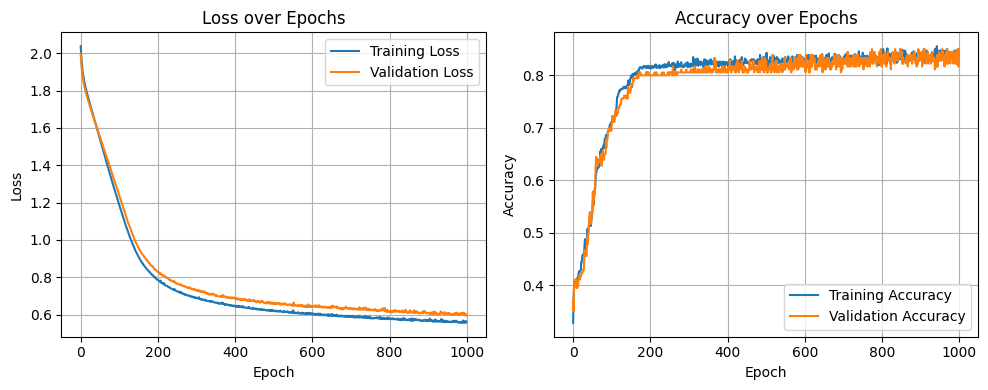

In [ ]:
#@title Gráfico de custo durante aprendizado
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.


    Args:
        history: A Keras History object.
    """
    plt.figure(figsize=(10, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

In [ ]:
val_loss, val_acc = model.evaluate(X_val, Y_val)
train_loss, train_acc = model.evaluate(X_train, Y_train)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.8411 - loss: 0.6112
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8393 - loss: 0.5648
Validation Loss: 0.5959
Validation Accuracy: 0.8500
Train Loss: 0.5507
Train Accuracy: 0.8472


#### Comentários:

Por fim, ao adicionar como regularização a função **L2** é notável a penalização mais forte dada pelo quadrado na fórmula de atualização da função de custo:

$C = C_0 + \frac{λ}{2n}\sum_w w^2$

que penaliza mais pesos muito grandes, trazendo de volta uma maior oscilação na curva de acurácia.

### Avaliação dos resultados
Com o último modelo com melhor acurácia de validação, é possível agora utilizar o conjunto de teste para avaliar realmente a eficácia deste modelo para um conjunto de dados não apresentado.

In [ ]:
test_error, test_acc = model.evaluate(X_test, Y_test)
print(f"Acurácia de teste:{test_acc:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7985 - loss: 0.6455
Acurácia de teste:0.84


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


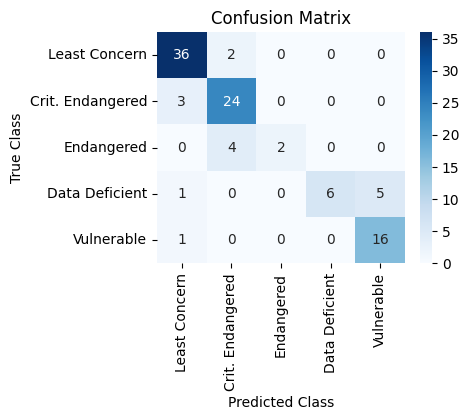

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(model, X_test, Y_test):
  # Make predictions on the test set
  Y_pred = model.predict(X_test)
  Y_pred_classes = np.argmax(Y_pred, axis=1)
  Y_true_classes = np.argmax(Y_test.values, axis=1) # Convert Y_test DataFrame to numpy array

  # Generate the confusion matrix
  cm = confusion_matrix(Y_true_classes, Y_pred_classes)

  # Get class names for labels
  class_names =['Least Concern', 'Crit. Endangered', 'Endangered', 'Data Deficient', 'Vulnerable'] # Use the original one-hot encoded column names

  # Plot the confusion matrix
  plt.figure(figsize=(4, 3))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')
  plt.title('Confusion Matrix')
  plt.show()


plot_confusion_matrix(model, X_test, Y_test)

# Predicting Abalone's age
O segundo problema que queremos resolver consistem em, com base em informações físicas sobre a concha, predizer a idade do molusco.
Iremos utilizar o banco de dados [**Student Performance**](https://archive.ics.uci.edu/dataset/320/student+performance)  que consiste em 33 atributos de mais de 4 mil abalones.

## Upload dos dados

In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
student_perform = fetch_ucirepo(id=320)

# data (as pandas dataframes)
X = student_perform.data.features
target = student_perform.data.targets

# variable information
display(student_perform.variables)


,name,role,type,demographic,description,units,missing_values
0,school,Feature,Categorical,None,student's school (binary: 'GP' - Gabriel Perei...,None,no
1,sex,Feature,Binary,Sex,student's sex (binary: 'F' - female or 'M' - m...,None,no
2,age,Feature,Integer,Age,student's age (numeric: from 15 to 22),None,no
3,address,Feature,Categorical,None,student's home address type (binary: 'U' - urb...,None,no
4,famsize,Feature,Categorical,Other,family size (binary: 'LE3' - less or equal to ...,None,no
5,Pstatus,Feature,Categorical,Other,parent's cohabitation status (binary: 'T' - li...,None,no
6,Medu,Feature,Integer,Education Level,"mother's education (numeric: 0 - none, 1 - pr...",None,no
7,Fedu,Feature,Integer,Education Level,"father's education (numeric: 0 - none, 1 - pr...",None,no
8,Mjob,Feature,Categorical,Occupation,"mother's job (nominal: 'teacher', 'health' car...",None,no
9,Fjob,Feature,Categorical,Occupation,"father's job (nominal: 'teacher', 'health' car...",None,no


In [3]:
X.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,1,1,3,4
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,1,1,3,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,yes,no,4,3,2,2,3,3,6
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,yes,3,2,2,1,1,5,0
4,GP,F,16,U,GT3,T,3,3,other,other,...,yes,no,no,4,3,2,1,2,5,0


A propriedade alvo consiste em nota dos alunos em cada um dos períodos do ano (G1, G2 e G3).

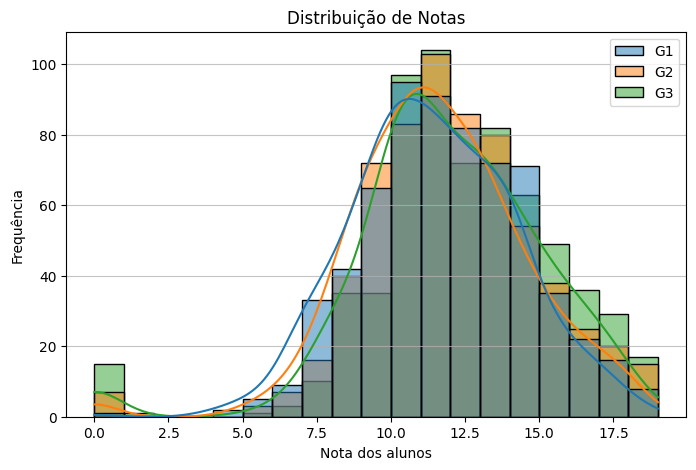

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

y = target
plt.figure(figsize=(8, 5))
sns.histplot(target, binwidth=1, kde=True, color='indigo')
plt.title('Distribuição de Notas')
plt.xlabel('Nota dos alunos')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

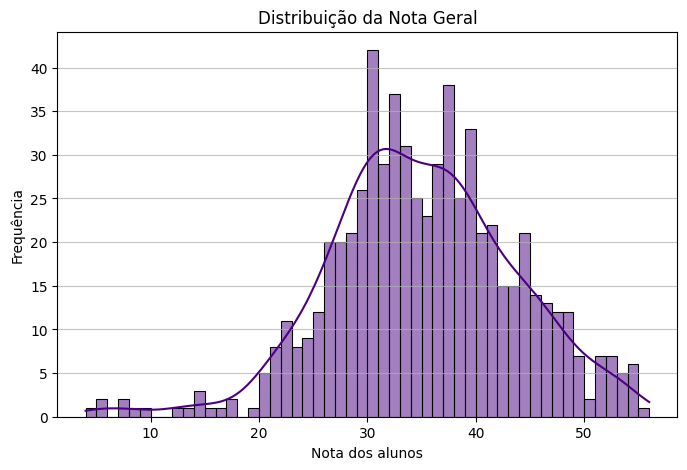

In [5]:
y = target['G1'] + target['G2'] + target['G3']
plt.figure(figsize=(8, 5))
sns.histplot(y, binwidth=1, kde=True, color='indigo')
plt.title('Distribuição da Nota Geral')
plt.xlabel('Nota dos alunos')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [6]:
import numpy as np

y = y.values.reshape(-1, 1)
print(y.shape)

(649, 1)


## Preparação dos dados

Temos 7 atributos continuos, que precisam ser normalizados e 1 atributo categórico que precisa ser codificado.
Vamos analisar a distribuição dos atributos contínuos para determinar se há outliers e se será necessário utilizar por distribuição ou por *minmaxScaler*

### Codificação
Analisar os valores para atributos categóricos.

In [7]:
import pandas as pd

categorical_cols = X.select_dtypes(include=['object']).columns
print("Colunas categóricas restantes:\n", categorical_cols.values)
[display(X[counts].value_counts()) for counts in categorical_cols]

Colunas categóricas restantes:
 ['school' 'sex' 'address' 'famsize' 'Pstatus' 'Mjob' 'Fjob' 'reason'
 'guardian' 'schoolsup' 'famsup' 'paid' 'activities' 'nursery' 'higher'
 'internet' 'romantic']


,count
school,
GP,423
MS,226


,count
sex,
F,383
M,266


,count
address,
U,452
R,197


,count
famsize,
GT3,457
LE3,192


,count
Pstatus,
T,569
A,80


,count
Mjob,
other,258
services,136
at_home,135
teacher,72
health,48


,count
Fjob,
other,367
services,181
at_home,42
teacher,36
health,23


,count
reason,
course,285
home,149
reputation,143
other,72


,count
guardian,
mother,455
father,153
other,41


,count
schoolsup,
no,581
yes,68


,count
famsup,
yes,398
no,251


,count
paid,
no,610
yes,39


,count
activities,
no,334
yes,315


,count
nursery,
yes,521
no,128


,count
higher,
yes,580
no,69


,count
internet,
yes,498
no,151


,count
romantic,
no,410
yes,239


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [8]:
encoded_df = pd.get_dummies(X, columns=categorical_cols)
display(encoded_df.head())

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,True,False,False,True,False,True,True,False,True,False
1,17,1,1,1,2,0,5,3,3,1,...,True,False,True,False,False,True,False,True,True,False
2,15,1,1,1,2,0,4,3,2,2,...,True,False,False,True,False,True,False,True,True,False
3,15,4,2,1,3,0,3,2,2,1,...,False,True,False,True,False,True,False,True,False,True
4,16,3,3,1,2,0,4,3,2,1,...,True,False,False,True,False,True,True,False,True,False


### Normalização

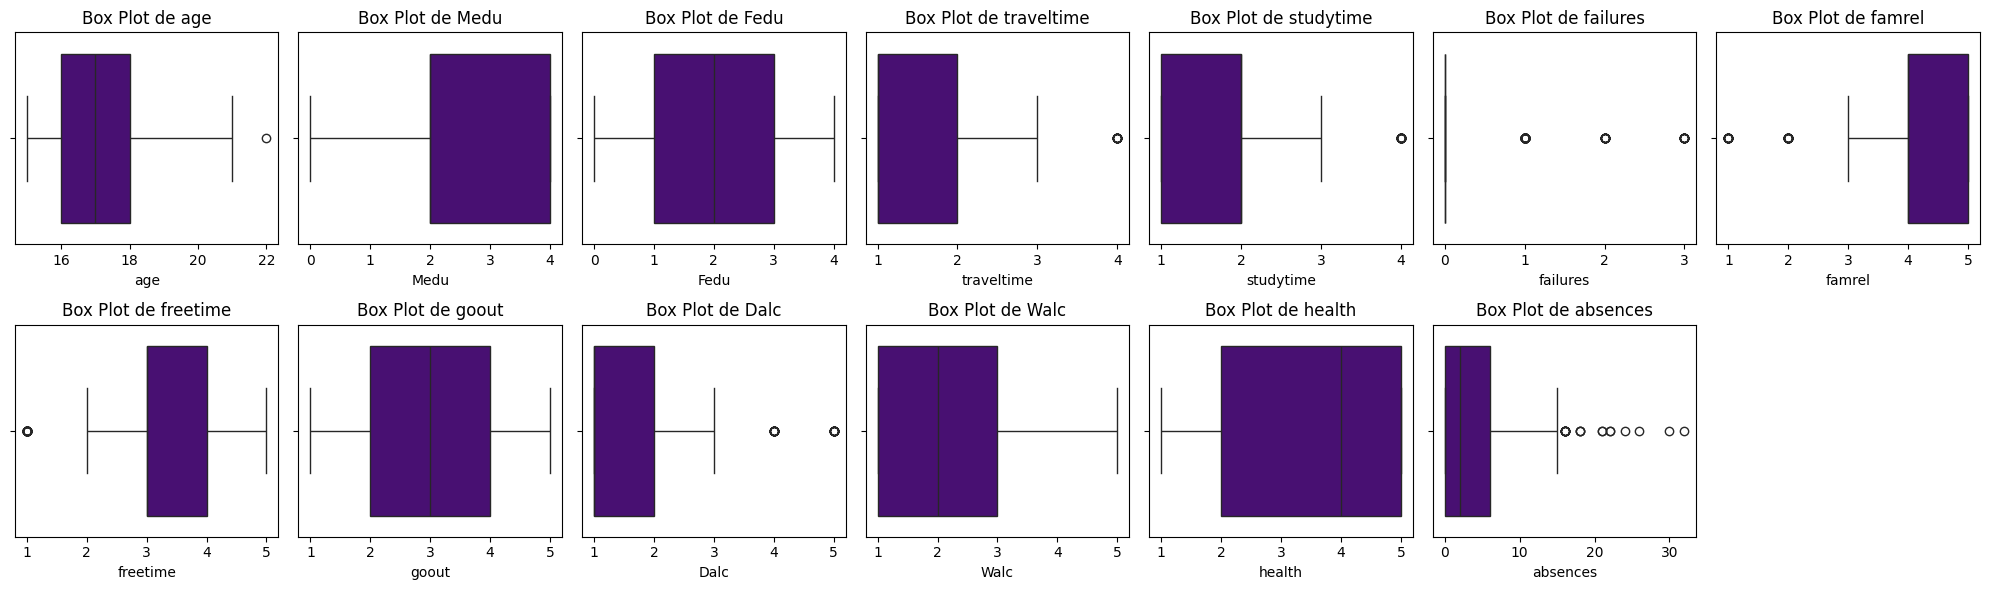

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000


In [9]:
numeric_cols = X.select_dtypes(include=['int', 'float64']).columns

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(20, 6))

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=X[col], ax=axes[i//7, i%7], color='indigo')
    axes[i//7, i%7].set_title(f'Box Plot de {col}')

axes[1, 6].axis('off')  # Desliga o eixo vazio se houver um número ímpar de colunas

plt.tight_layout()
plt.show()
display(X[numeric_cols].describe())

Existem alguns outliers em relação à faltas, mas não é tão grande em comparação à média. Portanto, podemos utilizar a MinMaxScaler

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
encoded_df[numeric_cols] = scaler.fit_transform(encoded_df[numeric_cols])
display(encoded_df[numeric_cols].describe())

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences
count,6.490000e+02,6.490000e+02,6.490000e+02,6.490000e+02,6.490000e+02,6.490000e+02,6.490000e+02,6.490000e+02,6.490000e+02,6.490000e+02,6.490000e+02,6.490000e+02,6.490000e+02
mean,-1.751723e-16,-1.094827e-16,-3.284481e-17,-7.663789e-17,9.579736e-17,3.284481e-17,-1.628555e-16,1.861206e-16,7.116376e-17,-3.284481e-17,7.937496e-17,-1.149568e-16,2.189654e-17
std,1.000771e+00,1.000771e+00,1.000771e+00,1.000771e+00,1.000771e+00,1.000771e+00,1.000771e+00,1.000771e+00,1.000771e+00,1.000771e+00,1.000771e+00,1.000771e+00,1.000771e+00
min,-1.432980e+00,-2.218124e+00,-2.098682e+00,-7.600319e-01,-1.122808e+00,-3.743051e-01,-3.068820e+00,-2.075896e+00,-1.859711e+00,-5.435553e-01,-9.976947e-01,-1.754987e+00,-7.891595e-01
25%,-6.114218e-01,-4.539544e-01,-1.188832e+00,-7.600319e-01,-1.122808e+00,-3.743051e-01,7.260615e-02,-1.716465e-01,-1.008546e+00,-5.435553e-01,-9.976947e-01,-1.063015e+00,-7.891595e-01
50%,2.101367e-01,-4.539544e-01,-2.789831e-01,-7.600319e-01,8.365295e-02,-3.743051e-01,7.260615e-02,-1.716465e-01,-1.573803e-01,-5.435553e-01,-2.185083e-01,3.209302e-01,-3.578630e-01
75%,1.031695e+00,1.310216e+00,6.308662e-01,5.767180e-01,8.365295e-02,-3.743051e-01,1.119748e+00,7.804783e-01,6.937850e-01,5.385533e-01,5.606780e-01,1.012903e+00,5.047298e-01
max,4.317929e+00,1.310216e+00,1.540715e+00,3.250218e+00,2.496576e+00,4.686612e+00,1.119748e+00,1.732603e+00,1.544950e+00,3.784879e+00,2.119051e+00,1.012903e+00,6.111583e+00


## Desenvolvimento de modelos
Faremos semelhante à classificação:

Divisão do dataset -> treinamento de modelos -> ajuste de hiperparâmetros -> retreino do modelo -> avaliação de resultados.

### Divisão do conjunto de dados

Diferente da classificação, aqui não faz tanto sentido utilizar divisão estratificada do conjunto de dados visto que a distribuição do *target* é uma normal.

In [11]:
from sklearn.model_selection import train_test_split

X_dev, X_test, Y_dev, Y_test = train_test_split(encoded_df, y, test_size=0.1, random_state=24)
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=0.2, random_state=24)

print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)

Tamanho do conjunto de treino: (467, 56)
Tamanho do conjunto de teste: (65, 56)


### Modelo 0 - MLP sem *momentum*
Utilizando os seguintes hiperparâmetros:
- 10 neurônios na camada oculta.
- $lr= 0.001$
- Treinamento em *batch* (tamanho = 100).

In [99]:
import keras
from keras.layers import Dense, Input

model0 = keras.Sequential()
model0.add(Input(shape=(X_train.shape[1],)))
model0.add(Dense(10, activation='relu'))
model0.add(Dense(Y_train.shape[1], activation='linear'))

In [100]:
from keras.optimizers import SGD

optimizer = SGD(learning_rate=0.001, momentum=0.0)
model0.compile(optimizer=optimizer, loss='mae', metrics=['r2_score'])

model0.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 10)             │           570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 581 (2.27 KB)

 Trainable params: 581 (2.27 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
history = model0.fit(X_train, Y_train, epochs=400,
                     validation_data=(X_val, Y_val),
                     batch_size=100, verbose=1)

Epoch 1/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 36.0624 - r2_score: -18.7551 - val_loss: 36.0388 - val_r2_score: -16.3649
Epoch 2/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 35.9851 - r2_score: -18.6743 - val_loss: 35.9638 - val_r2_score: -16.2963
Epoch 3/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 35.9094 - r2_score: -18.5957 - val_loss: 35.8905 - val_r2_score: -16.2294
Epoch 4/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 35.8354 - r2_score: -18.5185 - val_loss: 35.8188 - val_r2_score: -16.1639
Epoch 5/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 35.7625 - r2_score: -18.4431 - val_loss: 35.7484 - val_r2_score: -16.0998
Epoch 6/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 35.6908 - r2_score: -18.3688 - val_loss: 35.6794 - val_r2_score: -16.0370
Epoch 7/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 35.6202 - r2_score: -18.2961 - val_loss: 35.6113 - val_r2_score: -15.9753
Epoch 8/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 35.5510 - r2_scor

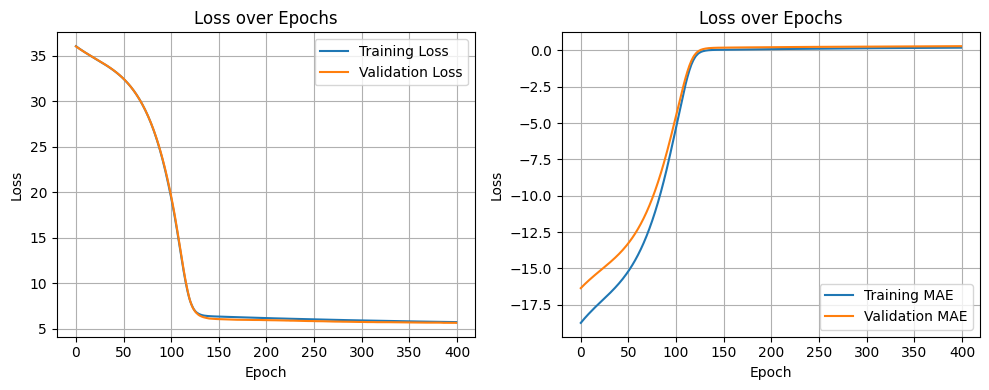

In [102]:
#@title Gráfico de custo durante aprendizado
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.


    Args:
        history: A Keras History object.
    """
    plt.figure(figsize=(10, 4))

    # Plot MSE Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.ylim(top=15, bottom=0)
    plt.legend()
    plt.grid(True)

    # Plot MAE Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['r2_score'], label='Training MAE')
    plt.plot(history.history['val_r2_score'], label='Validation MAE')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.ylim(top=1.5, bottom=0)
    plt.grid(True)


    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

In [103]:
val_loss, val_mae = model0.evaluate(X_val, Y_val)
print(f"Validation MAE Loss: {val_loss:.4f}")
print(f"Validation R2: {val_mae:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 5.6225 - r2_score: 0.2899
Validation MAE Loss: 5.6225
Validation R2: 0.2899


#### Comentários:

Pelo alto erro de treino, é possível observar que talvez o modelo precise de mais complexidade para conseguir prever esse problema.

### Modelo 1 - MLP sem *momentum*
Utilizando os seguintes hiperparâmetros:
- 3 camadas ocultas com 70, 15, e 5 neurônios cada.
- $lr= 0.001$
- Treinamento em *batch* (tamanho = 50).

In [77]:
import keras
from keras.layers import Dense, Input

model = keras.Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(70, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(Y_train.shape[1], activation='linear'))

In [78]:
from keras.optimizers import SGD

optimizer = SGD(learning_rate=0.001, momentum=0.0)
model.compile(optimizer=optimizer, loss='mae', metrics=['r2_score'])

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 70)             │         3,990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 15)             │         1,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 5)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,141 (20.08 KB)

 Trainable params: 5,141 (20.08 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
history = model.fit(X_train, Y_train, epochs=800,
                     validation_data=(X_val, Y_val),
                     batch_size=50, verbose=0)

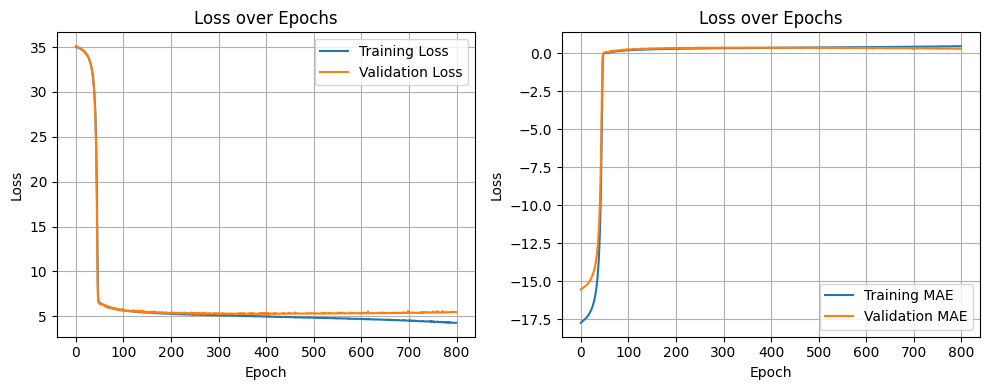

In [80]:
#@title Gráfico de custo durante aprendizado
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.


    Args:
        history: A Keras History object.
    """
    plt.figure(figsize=(10, 4))

    # Plot MAE Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.ylim(top=8, bottom=0)
    plt.legend()
    plt.grid(True)

    # Plot R2
    plt.subplot(1, 2, 2)
    plt.plot(history.history['r2_score'], label='Training MAE')
    plt.plot(history.history['val_r2_score'], label='Validation MAE')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.ylim(top=1.5, bottom=0)
    plt.grid(True)


    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

In [81]:
val_loss, val_mae = model.evaluate(X_val, Y_val)
print(f"Validation MAE: {val_loss:.4f}")
print(f"Validation R2: {val_mae:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 5.4686 - r2_score: 0.3127
Validation MAE: 5.4686
Validation R2: 0.3127


#### Comentários:

Ainda com uma arquitetura mais complexa, o modelo parece não conseguir descrever bem a relação entre atributos sociais e performance dos alunos. Isso nos dá duas opções:
- Aumentar a topologia da rede: aumentando o número de camadas ocultas e/ou aumentando o número de neurônios por camada -> no entanto, já estamos com uma rede devidamente complexa, e não houve melhora nos dados de treino.
- Conseguir mais dados.

Caso não seja possível melhorar tanto a arquitetura, podemos reavaliar a divisão do dataset. Talvez utilizar apenas o conjunto de desenvolvimento.  

### Modelo 2 - MLP sem *momentum*
Utilizando os seguintes hiperparâmetros:
- Mesmo número de camadas. 
- $lr= 0.001$
- Com regularização L2.
- Treinamento em *batch* (tamanho = 50).

In [104]:
import keras
from keras.layers import Dense, Input

model = keras.Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(70, activation='relu', kernel_regularizer='l2'))
model.add(Dense(15, activation='relu', kernel_regularizer='l2'))
model.add(Dense(5, activation='relu', kernel_regularizer='l2'))
model.add(Dense(Y_train.shape[1], activation='linear'))

In [105]:
from keras.optimizers import SGD

optimizer = SGD(learning_rate=0.001, momentum=0.0)
model.compile(optimizer=optimizer, loss='mae', metrics=['r2_score'])

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_58 (Dense)                │ (None, 70)             │         3,990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 15)             │         1,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 5)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,141 (20.08 KB)

 Trainable params: 5,141 (20.08 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
history = model.fit(X_train, Y_train, epochs=800,
                     validation_data=(X_val, Y_val),
                     batch_size=50, verbose=0)

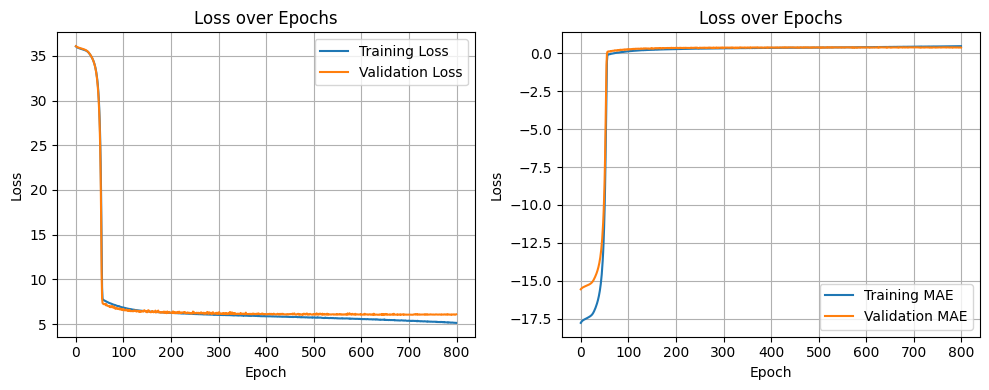

In [107]:
#@title Gráfico de custo durante aprendizado
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.


    Args:
        history: A Keras History object.
    """
    plt.figure(figsize=(10, 4))

    # Plot MAE Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.ylim(top=8, bottom=0)
    plt.legend()
    plt.grid(True)

    # Plot R2
    plt.subplot(1, 2, 2)
    plt.plot(history.history['r2_score'], label='Training MAE')
    plt.plot(history.history['val_r2_score'], label='Validation MAE')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.ylim(top=1.5, bottom=0)
    plt.grid(True)


    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

In [108]:
val_loss, val_mae = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation MAE: {val_mae:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 6.0819 - r2_score: 0.3831
Validation Loss: 6.0819
Validation MAE: 0.3831


#### Comentários:

Ainda não é possível ter uma eficácia boa para o modelo. Mas já dá pra ver um impacto da regularização L2 na curva de treinamento. Onde as curvas de validação e treino ficam mais coladas.

### Modelo 3 - MLP com *momentum*
Utilizando os seguintes hiperparâmetros:
-  neurônios na camada oculta.
- $lr= 0.001$
- Treinamento em *batch* (tamanho = 100).

In [94]:
import keras
from keras.layers import Dense, Input

model = keras.Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(70, activation='relu', kernel_regularizer='l2'))
model.add(Dense(15, activation='relu', kernel_regularizer='l2'))
model.add(Dense(5, activation='relu', kernel_regularizer='l2'))
model.add(Dense(Y_train.shape[1], activation='linear'))


In [95]:
from keras.optimizers import SGD

optimizer = SGD(learning_rate=0.001, momentum=0.8)
model.compile(optimizer=optimizer, loss='mae', metrics=['r2_score'])

model.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 70)             │         3,990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 15)             │         1,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 5)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,141 (20.08 KB)

 Trainable params: 5,141 (20.08 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
history = model.fit(X_train, Y_train, epochs=800,
                     validation_data=(X_val, Y_val),
                     batch_size=50, verbose=0)


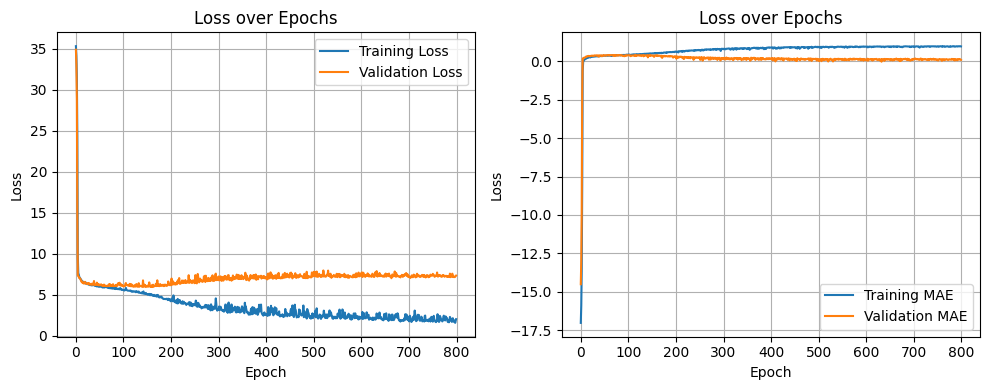

In [97]:
#@title Gráfico de custo durante aprendizado
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.


    Args:
        history: A Keras History object.
    """
    plt.figure(figsize=(10, 4))

    # Plot MAE Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.ylim(top=8, bottom=0)
    plt.legend()
    plt.grid(True)

    # Plot R2
    plt.subplot(1, 2, 2)
    plt.plot(history.history['r2_score'], label='Training MAE')
    plt.plot(history.history['val_r2_score'], label='Validation MAE')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.ylim(top=1.5, bottom=0)
    plt.grid(True)


    plt.tight_layout()
    plt.show()

plot_learning_curve(history)


In [98]:
val_loss, val_mae = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation MAE: {val_mae:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 7.3339 - r2_score: 0.0822 
Validation Loss: 7.3339
Validation MAE: 0.0822


#### Comentários:

Adicionar *momentum* aumenta muito a oscilação da curva de treino e *overfitting*, mostrando que talvez o *momentum* não seja a melhor opção sempre.

### Avaliação dos resultados
Utilizando o melhor modelo (modelo 2) que conseguiu um R2 de validação próximo de 0.40. 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Test MAE: 4.9390
Test MSE: 51.6822
Test RMSE: 7.1890
Test R²: 0.3479


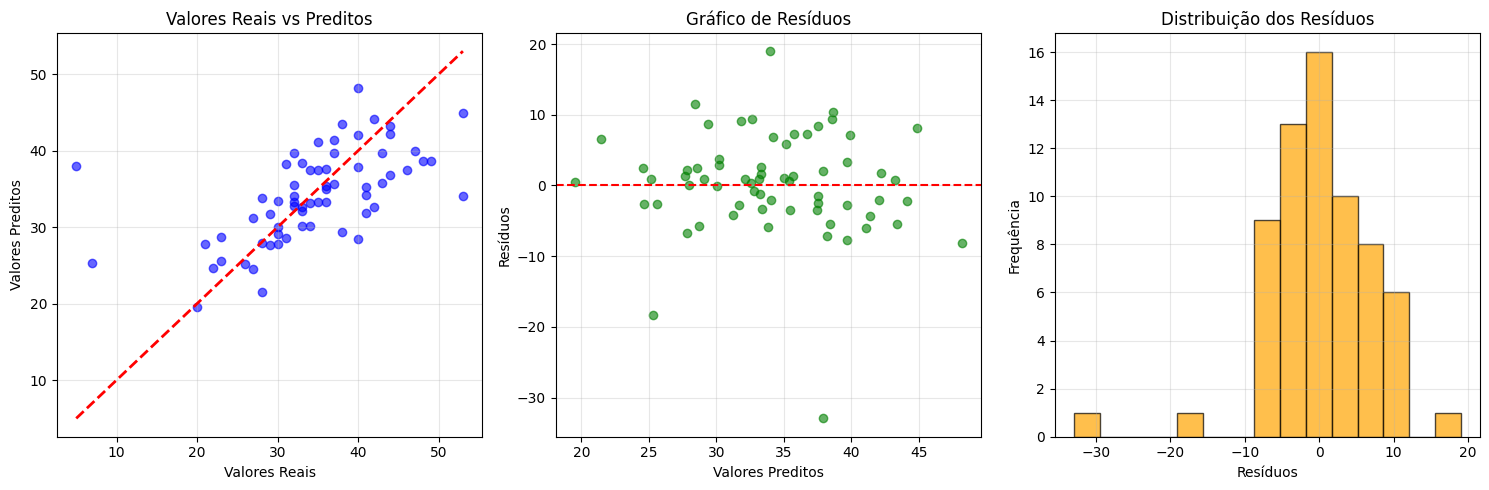

In [109]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Fazer predições no conjunto de teste
Y_test_pred = model.predict(X_test)

# Calcular métricas de avaliação

test_mae = mean_absolute_error(Y_test, Y_test_pred)
test_mse = mean_squared_error(Y_test, Y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(Y_test, Y_test_pred)

print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Criar gráficos de avaliação
plt.figure(figsize=(15, 5))

# Gráfico 1: Valores Reais vs Preditos
plt.subplot(1, 3, 1)
plt.scatter(Y_test, Y_test_pred, alpha=0.6, color='blue')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Reais vs Preditos')
plt.grid(True, alpha=0.3)

# Gráfico 2: Resíduos
plt.subplot(1, 3, 2)
residuals = Y_test.flatten() - Y_test_pred.flatten()
plt.scatter(Y_test_pred, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Gráfico de Resíduos')
plt.grid(True, alpha=0.3)

# Gráfico 3: Distribuição dos Resíduos
plt.subplot(1, 3, 3)
plt.hist(residuals, bins=15, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()